### Import Dependecies

In [1]:
import os
import copy
import torch
import cv2
from tqdm import tqdm
import pandas as pd
import detectron2
import pickle
import math
import matplotlib.pyplot as plt
from detectron2.data import detection_utils as utils
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer

### Register Dataset

In [2]:
# format: register_coco_instances(name, metadata, json_file, image_root):
# name = dataset name
# once you have registered the dataset, you can use the name of the dataset in cfg.DATASETS.{TRAIN,TEST}
register_coco_instances(name='coco_trash_train', metadata={}, json_file='../../../dataset/train.json', image_root='../../../dataset/')
register_coco_instances(name='coco_trash_test',  metadata={}, json_file='../../../dataset/test.json',  image_root='../../../dataset/')

# revise metadata
MetadataCatalog.get('coco_trash_train').thing_classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

### Load Config

In [3]:
# config 불러오기
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))

In [4]:
# config 수정하기
cfg.DATASETS.TEST = ('coco_trash_test',)
cfg.DATALOADER.NUM_WOREKRS = 2
cfg.OUTPUT_DIR = '../output'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3

### Create Predictor & Mapper

In [5]:
# model
predictor = DefaultPredictor(cfg)

# mapper - input data를 어떤 형식으로 return할지
def MyMapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict['file_name'], format='BGR')
    
    dataset_dict['image'] = image
    
    return dataset_dict

# test loader
test_loader = build_detection_test_loader(cfg, 'coco_trash_test', MyMapper)

[05/08 06:28:25 d2.data.datasets.coco]: Loaded 4871 images in COCO format from ../../../dataset/test.json
[05/08 06:28:25 d2.data.build]: Distribution of instances among all 10 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
| General trash | 0            |    Paper    | 0            | Paper pack | 0            |
|     Metal     | 0            |    Glass    | 0            |  Plastic   | 0            |
|   Styrofoam   | 0            | Plastic bag | 0            |  Battery   | 0            |
|   Clothing    | 0            |             |              |            |              |
|     total     | 0            |             |              |            |              |
[05/08 06:28:25 d2.data.common]: Serializing 4871 elements to byte tensors and concatenating them all ...
[05/08 06:28:25 d2.data.common]: Serialized dataset takes 0.53 MiB


### Inference

In [6]:
# Make submission file (Detectron2 only)
prediction_strings = []
file_names = []
class_num = 10

for data in tqdm(test_loader):
    
    prediction_string = ''
    
    data = data[0]
    
    outputs = predictor(data['image'])['instances']
    
    targets = outputs.pred_classes.cpu().tolist()
    boxes = [i.cpu().detach().numpy() for i in outputs.pred_boxes]
    scores = outputs.scores.cpu().tolist()
    
    for target, box, score in zip(targets,boxes,scores):
        prediction_string += (str(target) + ' ' + str(score) + ' ' + str(box[0]) + ' ' 
        + str(box[1]) + ' ' + str(box[2]) + ' ' + str(box[3]) + ' ')
    
    prediction_strings.append(prediction_string)
    file_names.append(data['file_name'].replace('../../dataset/',''))

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.OUTPUT_DIR, f'submission_det2.csv'), index=None)

  0%|          | 0/4871 [00:00<?, ?it/s]/opt/ml/baseline/detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()
100%|██████████| 4871/4871 [05:47<00:00, 14.04it/s]


### Generate Pickle

In [136]:
# Takes 3 minutes to complete
# If you're hesitant to wait, then just load pickle the file I provided to you. No need to run this cell!
my_dataset_train_metadata = MetadataCatalog.get("coco_trash_train")

images_test_dataset   = []
images_data_collector = []
for idx, data in tqdm(enumerate(test_loader)):
    data = data[0] 
    images_data_collector.append(data)
    
    if idx % 16 == 0:
        images_test_dataset.append(images_data_collector)
        images_data_collector = []

with open('image_test_dataset.txt', 'wb') as f: # create the pickle file in the current directory (pickle file name: image_test_dataset.txt)
    pickle.dump(images_test_dataset, f)

4871it [01:05, 73.83it/s]


### Load Pickle File

In [6]:
with open('image_test_dataset.txt', 'rb') as f:
    loaded_pickle = pickle.load(f)

# if the output is 305, your good to go!
print(len(loaded_pickle)) # takes 2 mins

305


### Demo
* Individual Output
* Group Output

In [7]:
### individual output
def individual_image(test_dataset, id): 
    top_six_last_image = [4865, 4866, 4867, 4868, 4869, 4870]
    my_dataset_train_metadata = MetadataCatalog.get("coco_trash_train")
    if id in top_six_last_image:
        for idx, data in tqdm(enumerate(test_dataset)):
            if idx == id:
                data = data[0]
                img_data = cv2.imread(f"../../../dataset/test/{str(id)}.jpg")
                outputs = predictor(data['image'])['instances']
                visualizer = Visualizer(img_data[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
                out = visualizer.draw_instance_predictions(outputs.to('cpu'))
                image = out.get_image()[:, :, ::-1]
                plt.figure()
                plt.title(f"test/{str(id)}.jpg")
                plt.imshow(image)
                plt.axis('off')

    else:
        original_number = id
        id = math.ceil(id / 16)
        for idx, data in enumerate(test_dataset):
            if idx == id:
                tmp = data
                data = data[0]
                start_number = int(data['file_name'][-8:-4])
                for idx2, data2 in enumerate(tmp, start=0):
                    if idx2 == original_number-start_number:
                        img_data = cv2.imread(f"../../../dataset/test/{str(original_number).zfill(4)}.jpg")
                        outputs = predictor(data2['image'])['instances']
                        visualizer = Visualizer(img_data[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
                        out = visualizer.draw_instance_predictions(outputs.to('cpu'))
                        image = out.get_image()[:, :, ::-1]
                        plt.figure()
                        plt.title(f"test/{str(original_number).zfill(4)}.jpg")
                        plt.imshow(image)
                        plt.axis('off')

### Individual Image

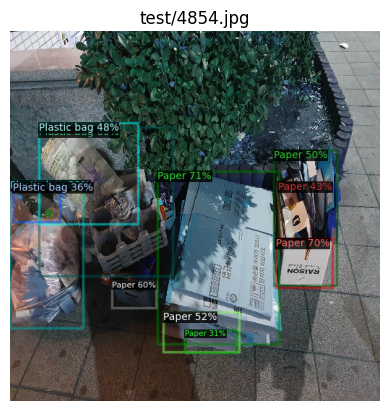

In [158]:
# with pickle file
individual_image(loaded_pickle, 4854) # loaded pickle file

# without pickle file
# individual_image(images_test_dataset, 4854)

#### Individual Image (4865~4870 Only)

4871it [01:04, 75.23it/s]


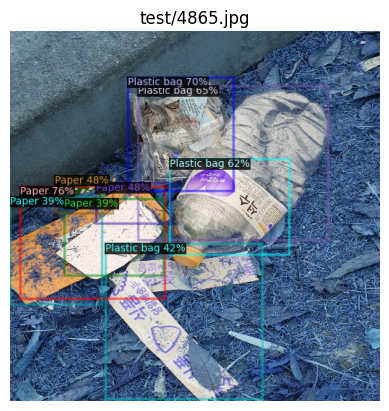

In [161]:
individual_image(test_loader, 4865) # takes 1 min... O(N)때문에.. 헤헷 미안! (＾◇^)/

### Group Output

In [22]:
def group_image(test_dataset, idx):
    '''
    idx 0:   0000
    idx 1:   0001~0016
    idx 2:   0017~0032
    idx 304: 4848~4864
    '''
    fig, axes = plt.subplots(4, 4, figsize=(12,12), dpi=120)
    axes = axes.flatten()

    my_dataset_train_metadata = MetadataCatalog.get("coco_trash_train")
    if idx == 0:
        picture_number = [0]
    else:
        picture_number = [i for i in range((idx*16)-15, ((idx+1)*16)-15)]

    for idx, (data, pic_num) in enumerate(zip(test_dataset[idx], picture_number), start=0):
        img_data = cv2.imread(data['file_name'])
        outputs = predictor(data['image'])['instances']
        visualizer = Visualizer(img_data[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
        out = visualizer.draw_instance_predictions(outputs.to('cpu'))
        image = out.get_image()[:, :, ::-1]
        pic_num = str(pic_num).zfill(4)
        axes[idx].imshow(image)
        axes[idx].set_title(f"test/{pic_num}.jpg")
        axes[idx].axis('off')


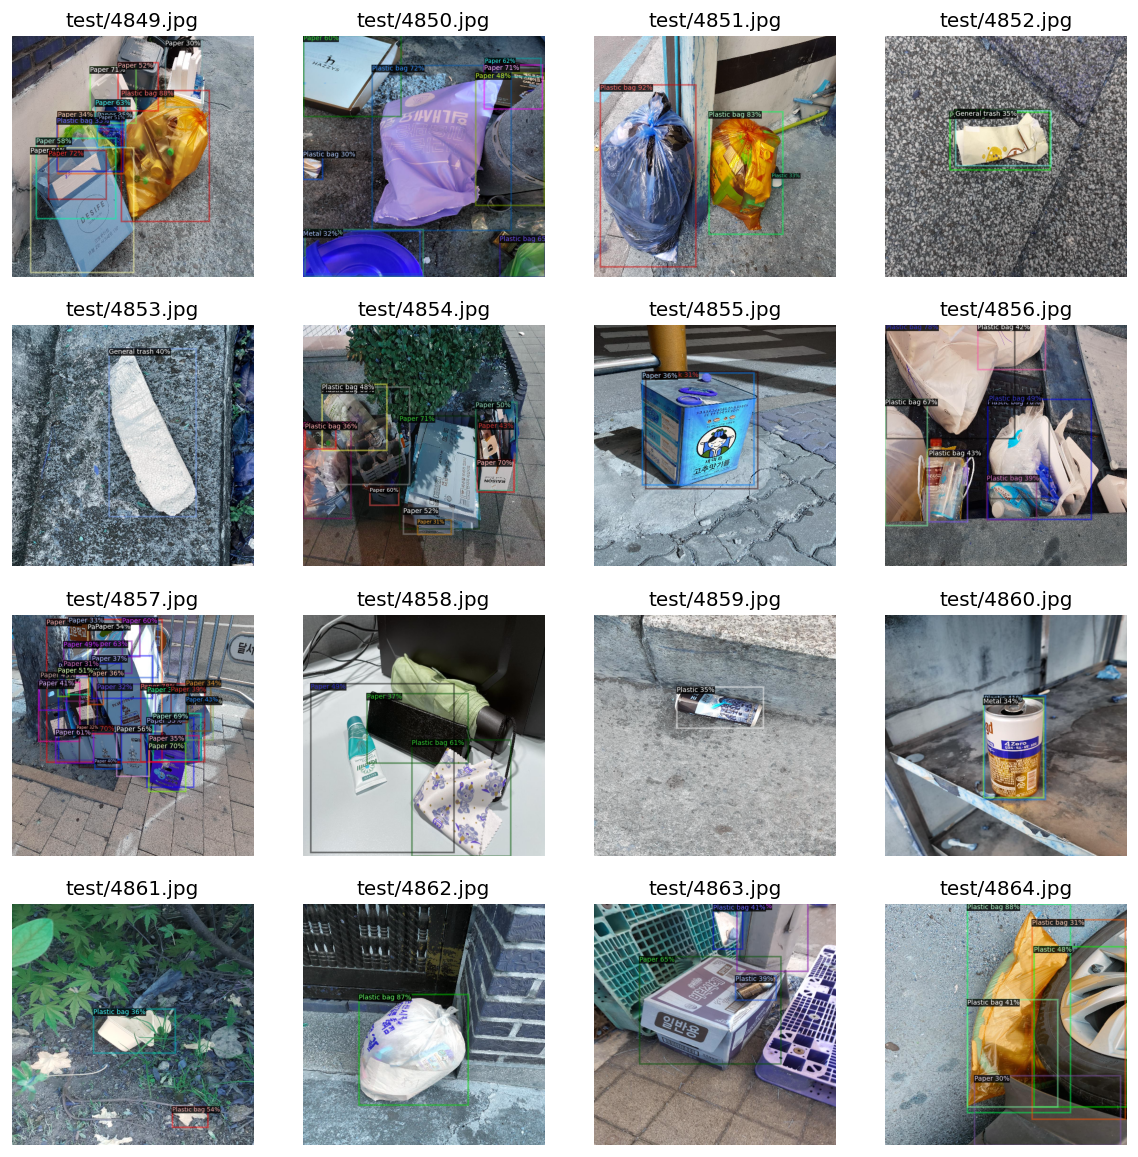

In [164]:
# select from 0 ~ 304
# with pickle file
group_image(loaded_pickle, 304)

# without pickle file
#group_image(images_test_dataset, 304)